In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  
  """
  A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.  
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


In [13]:
Image(filename='notMNIST_small/A/MDEtMDEtMDAudHRm.png')

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A
Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '.\\notMNIST_large\\A\\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '.\\notMNIST_large\\A\\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '.\\notMNIST_large\\A\\Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B
Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file '.\\notMNIST_large\\B\\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.

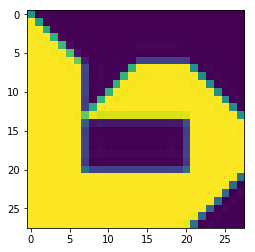

In [7]:
with open(train_datasets[1], 'rb') as f:
    letter_set = pickle.load(f)
    plt.imshow(letter_set[0])

In [12]:
for pickle_file_train in train_datasets:
    # encoding needs to be added beacuse pickle file was creted in python2
    letter_set_train = pickle.load(open(pickle_file_train, 'rb'), encoding='latin1')
    print(pickle_file_train, ": ", len(letter_set_train))
for pickle_file_test in test_datasets:
    # encoding needs to be added beacuse pickle file was creted in python2
    letter_set_test = pickle.load(open(pickle_file_test, 'rb'), encoding='latin1')
    print(pickle_file_test, ": ", len(letter_set_test))

.\notMNIST_large\A.pickle :  52909
.\notMNIST_large\B.pickle :  52911
.\notMNIST_large\C.pickle :  52912
.\notMNIST_large\D.pickle :  52911
.\notMNIST_large\E.pickle :  52912
.\notMNIST_large\F.pickle :  52912
.\notMNIST_large\G.pickle :  52912
.\notMNIST_large\H.pickle :  52912
.\notMNIST_large\I.pickle :  52912
.\notMNIST_large\J.pickle :  52911
.\notMNIST_small\A.pickle :  1872
.\notMNIST_small\B.pickle :  1873
.\notMNIST_small\C.pickle :  1873
.\notMNIST_small\D.pickle :  1873
.\notMNIST_small\E.pickle :  1873
.\notMNIST_small\F.pickle :  1872
.\notMNIST_small\G.pickle :  1872
.\notMNIST_small\H.pickle :  1872
.\notMNIST_small\I.pickle :  1872
.\notMNIST_small\J.pickle :  1872


In [14]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [15]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

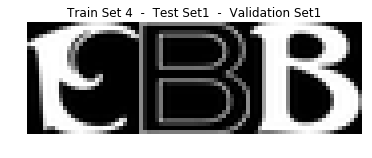

In [20]:
import time
from IPython.display import clear_output

for i in np.random.randint(0, 1000, 10):
    clear_output(wait="Ture")
    plt.imshow(np.hstack((train_dataset[i, :, :], test_dataset[i, :, :], valid_dataset[i, :, :])), cmap = 'gray')
    plt.title("Train Set " + str(train_labels[i]) + 
              "  -  Test Set" + str(test_labels[i]) + 
              "  -  Validation Set" + str(valid_labels[i]))
    plt.axis('off')
    plt.show()
    time.sleep(5)

In [21]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [22]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


In [25]:
def are_equal(img1, img2):
    row = img1.shape[0] / 2
    if np.array_equal(img1[row, :], img2[row, :]):
        return np.array_equal(img1, img2)
    else:
        return False

def find_duplicates(labels1, dataset1, labels2=None, dataset2=None):
    classes = np.unique(labels1)
    duplicate_index = []
    try:
        if not labels2:
            for _class in classes:
                num_duplicates = 0
                index = np.where(labels1 == _class)[0]
                combinations = list(it.combinations(range(len(index)), 2))
                print("Comparisons to make for this class:", len(combinations) / float(1000000), "million")
                for i,j in combinations:
                    img1 = dataset1[i]
                    img2 = dataset1[j]
                    if are_equal(img1, img2) == True:
                        duplicate_index.append((i ,j))
                        num_duplicates += 1
                print("The number of matches found in class %d is %d\n" %(_class, num_duplicates))
            print("Total of matches: %d from a sample size: %d \n\n" %(len(duplicate_index), len(labels1)))
    
    except:
        for _class in classes:
            num_duplicates = 0
            index1 = np.where(labels1 == _class)[0]
            index2 = np.where(labels2 == _class)[0]
            print("Comparisons to make for this class:", len(index1) * len(index1) / float(1000000) / 2 , "million\n")
            for i in index1:
                for j in index2:
                    if j >= i:
                        img1 = dataset1[i]
                        img2 = dataset2[j]
                        if are_equal(img1, img2) == True:
                            duplicate_index.append((i ,j))
                            num_duplicates += 1
            print("The number of matches found in class %d is %d" %(_class, num_duplicates))
        print("Total of matches: %d from a sample size: %d \n\n" %(len(duplicate_index), len(labels1)))
    return duplicate_index
         
# duplicate_index_valid = find_duplicates(valid_labels, valid_dataset)
# duplicate_index_test = find_duplicates(test_labels, test_dataset)
# duplicate_index_train = find_duplicates(train_labels, train_dataset)

Comparisons to make for this class: 200.0 million

The number of matches found in class 0 is 0
Comparisons to make for this class: 200.0 million

The number of matches found in class 1 is 0
Comparisons to make for this class: 200.0 million

The number of matches found in class 2 is 0
Comparisons to make for this class: 200.0 million

The number of matches found in class 3 is 0
Comparisons to make for this class: 200.0 million

The number of matches found in class 4 is 0
Comparisons to make for this class: 200.0 million

The number of matches found in class 5 is 0
Comparisons to make for this class: 200.0 million

The number of matches found in class 6 is 0
Comparisons to make for this class: 200.0 million

The number of matches found in class 7 is 0
Comparisons to make for this class: 200.0 million

The number of matches found in class 8 is 0
Comparisons to make for this class: 200.0 million

The number of matches found in class 9 is 0
Total of matches: 0 from a sample size: 200000 




In [28]:
pickle_file = 'notMNIST.pickle'

dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

print("Examples in train dataset:", len(train_labels) / float(1000), "thousand")
print("Examples in valid dataset:", len(valid_labels) / float(1000), "thousand")
print("Examples in test dataset:", len(test_labels) / float(1000), "thousand")

Examples in train dataset: 200.0 thousand
Examples in valid dataset: 10.0 thousand
Examples in test dataset: 10.0 thousand


In [35]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

def train_and_validate(num_examples):
    # flatten datasets
    flat_train = [x.flatten() for x in train_dataset[:num_examples]]
    flat_valid = [x.flatten() for x in valid_dataset[:num_examples]]
#     print(train_labels[:num_examples]) # Check if labels are really shuffled
    model = LogisticRegressionCV().fit(flat_train, train_labels[:num_examples])
    score = cross_val_score(model, flat_valid, valid_labels[:num_examples]).mean()
    return score

training_sizes = [100, 1000, 5000, 50000]
print("Cross Validation Score\n")
for size in training_sizes:
    %time score = train_and_validate(size)
    print("Samples:", size,"---> Score:", score)

Cross Validation Score

Wall time: 5.66 s
Samples: 100 ---> Score: 0.609903316165
Wall time: 19.8 s
Samples: 1000 ---> Score: 0.757924555364
Wall time: 3min 50s
Samples: 5000 ---> Score: 0.805396609358
Wall time: 17min 28s
Samples: 50000 ---> Score: 0.809906313499
